In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1),  # 1*3*3*4 + 4 = 40 params
            nn.ReLU(),
            nn.BatchNorm2d(4),              # 8 params
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3, padding=1),  # 4*3*3*8 + 8 = 296 params
            nn.ReLU(),
            nn.BatchNorm2d(8),              # 16 params
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 12, 3, padding=1), # 8*3*3*12 + 12 = 876 params
            nn.ReLU(),
            nn.BatchNorm2d(12),             # 24 params
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        # 12 channels * 3 * 3 = 108 neurons after three max pools (28->14->7->3)
        self.fc1 = nn.Linear(12 * 3 * 3, 10)  # 108*10 + 10 = 1090 params
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)  # Flatten
        x = F.dropout(x, p=0.1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [3]:
#!pip install torchinfo
from torchinfo import summary
use_cuda = torch.cuda.is_available()
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if use_cuda else "cpu")
model = Net().to(device)
# Create a dummy input tensor on the correct device
summary(model, input_size=(1, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─MaxPool2d: 2-4                    [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─Conv2d: 2-5                       [1, 8, 14, 14]            296
│    └─ReLU: 2-6                         [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-7                  [1, 8, 14, 14]            16
│    └─MaxPool2d: 2-8                    [1, 8, 7, 7]              --
│    └─Dropout: 2-9                      [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─Conv2d: 

In [4]:


torch.manual_seed(1456)
batch_size = 512

kwargs = {'num_workers': 0, 'pin_memory': True} if device.type in ["cuda", "mps"] else {}
# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                     transform=transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.1307,), (0.3081,))
#                     ])),
#     batch_size=batch_size, shuffle=True, **kwargs)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.Compose([
#                         transforms.ToTensor(),
#                         transforms.Normalize((0.1307,), (0.3081,))
#                     ])),
#     batch_size=batch_size, shuffle=True, **kwargs)


import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import cv2
import random
# Define the augmentation pipeline
train_transforms = A.Compose([
    A.ShiftScaleRotate(
        shift_limit=0.0625,
        scale_limit=0.1,
        rotate_limit=15,
        p=0.7,
        border_mode=cv2.BORDER_CONSTANT,
        value=0
    ),
    A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.3),
    A.GaussNoise(var_limit=(5.0, 30.0), p=0.3),
    A.Perspective(scale=(0.05, 0.1), p=0.3, keep_size=True, pad_mode=cv2.BORDER_CONSTANT, pad_val=0),

    A.ElasticTransform(
         alpha=1.0,
         sigma=10.0,
         alpha_affine=None,  # Set to None as required by newer versions
         interpolation=cv2.INTER_LINEAR,
         border_mode=cv2.BORDER_CONSTANT,
         value=0,
         p=0.3
    ),
    
    # CoarseDropout as alternative to regular dropout
    A.CoarseDropout(
        max_holes=2,
        max_height=8,
        max_width=8,
        min_holes=1,
        fill_value=0,
        p=0.2
    ),

    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

# Custom Dataset class to work with Albumentations
class MNISTAlbumentations(datasets.MNIST):
    def __init__(self, root, train=True, download=True, transform=None):
        super().__init__(root, train=train, download=download, transform=None)
        self.transform = transform
        
    def __getitem__(self, idx):
        img, label = self.data[idx], self.targets[idx]
        
        # Convert to numpy array and add channel dimension
        img = np.array(img)
        img = np.expand_dims(img, axis=-1)  # Add channel dimension for Albumentations
        
        if self.transform is not None:
            transformed = self.transform(image=img)
            img = transformed["image"]
            
        return img, label


# Update the data loaders
train_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=True, download=True, transform=train_transforms),
    batch_size=batch_size, shuffle=True, 
    **kwargs)

# Test transforms (only normalization, no augmentation)
test_transforms = A.Compose([
    A.Normalize(
        mean=[0.1307],
        std=[0.3081],
    ),
    ToTensorV2(),
])

test_loader = torch.utils.data.DataLoader(
    MNISTAlbumentations('../data', train=False, transform=test_transforms),
    batch_size=batch_size, shuffle=True,  
    **kwargs)

# Optional: Visualization function to check augmentations
def visualize_augmentations(dataset, idx=0, samples=5):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(20, 4))
    for i in range(samples):
        data = dataset[idx][0]
        if isinstance(data, torch.Tensor):
            data = data.numpy()
        if data.shape[0] == 1:  # If channels first, move to last
            data = np.transpose(data, (1, 2, 0))
        plt.subplot(1, samples, i + 1)
        plt.imshow(data.squeeze(), cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()



/Users/dhairyashil/miniconda3/envs/erav2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/dhairyashil/miniconda3/envs/erav2/lib/python3.12/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


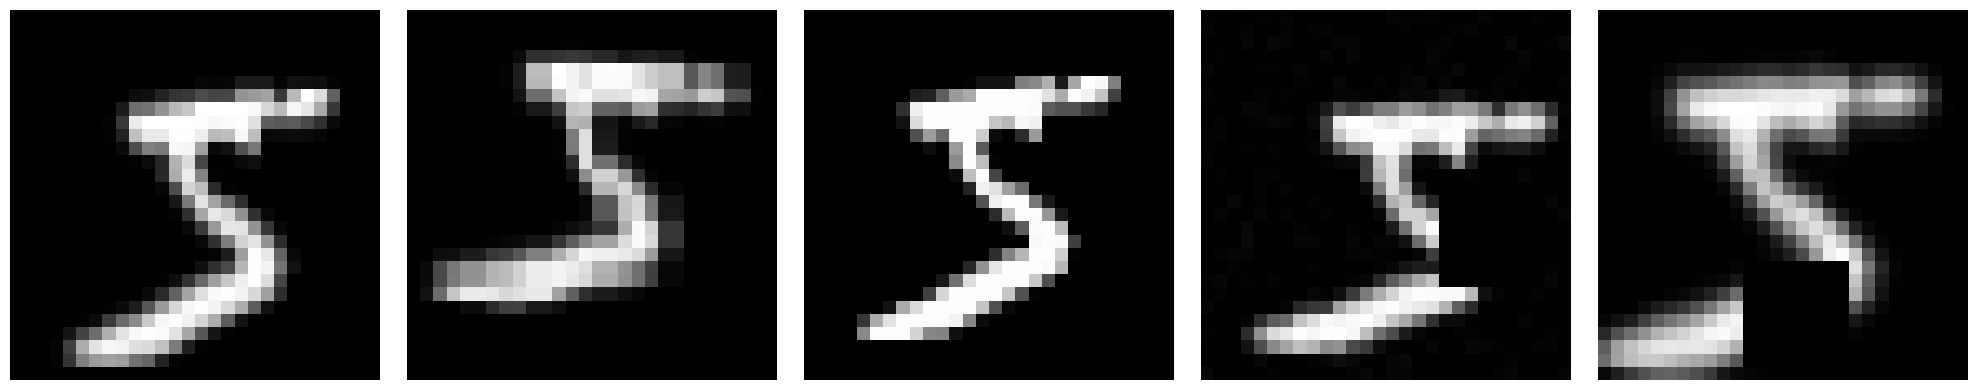

Number of samples in train dataset: 60000
Number of samples in test dataset: 10000


In [5]:
# Uncomment to visualize augmentations
visualize_augmentations(train_loader.dataset)

# # print number of samples in train and test dataset
print(f"Number of samples in train dataset: {len(train_loader.dataset)}")
print(f"Number of samples in test dataset: {len(test_loader.dataset)}")


In [6]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    model.train()
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if scheduler:
            scheduler.step()
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 14):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1),  # 1*3*3*4 + 4 = 40 params
            nn.ReLU(),
            nn.BatchNorm2d(4),              # 8 params
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3, padding=1),  # 4*3*3*8 + 8 = 296 params
            nn.ReLU(),
            nn.BatchNorm2d(8),              # 16 params
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 12, 3, padding=1), # 8*3*3*12 + 12 = 876 params
            nn.ReLU(),
            nn.BatchNorm2d(12),             # 24 params
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        # 12 channels * 3 * 3 = 108 neurons after three max pools (28->14->7->3)
        self.fc1 = nn.Linear(12 * 3 * 3, 10)  # 108*10 + 10 = 1090 params
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)  # Flatten
        x = F.dropout(x, p=0.1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)


==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─MaxPool2d: 2-4                    [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─Conv2d: 2-5                       [1, 8, 14, 14]            296
│    └─ReLU: 2-6                         [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-7                  [1, 8, 14, 14]            16
│    └─MaxPool2d: 2-8                    [1, 8, 7, 7]              --
│    └─Dropout: 2-9                      [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─Conv2d: 2-10                      [1, 12, 7, 7]             876
│    └─ReLU: 2-11                        [1, 12, 7, 7]             --
│    └─BatchNorm2d: 2-12                 [1, 12, 7, 7]             24
│    └─MaxPool2d: 2-13                   [1, 12, 3, 3]             --
│    └─Dropout: 2-14                     [1, 12, 3, 3]             --
├─Linear: 1-4                            [1, 10]                   1,090
==========================================================================================
Total params: 2,350
Trainable params: 2,350
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.13
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.01
Estimated Total Size (MB): 0.10
==========================================================================================


loss=0.46857449412345886 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.72it/s]

Test set: Average loss: 0.1879, Accuracy: 9446/10000 (94.46%)

loss=0.3038197457790375 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.82it/s] 

Test set: Average loss: 0.1234, Accuracy: 9638/10000 (96.38%)

loss=0.37657299637794495 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.80it/s]

Test set: Average loss: 0.1038, Accuracy: 9687/10000 (96.87%)

loss=0.46292558312416077 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.86it/s]

Test set: Average loss: 0.0889, Accuracy: 9728/10000 (97.28%)

loss=0.33317264914512634 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.80it/s]

Test set: Average loss: 0.0854, Accuracy: 9733/10000 (97.33%)

loss=0.29084160923957825 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s]

Test set: Average loss: 0.0799, Accuracy: 9766/10000 (97.66%)

loss=0.41878804564476013 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.77it/s]

Test set: Average loss: 0.0801, Accuracy: 9744/10000 (97.44%)

loss=0.2115659862756729 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s] 

Test set: Average loss: 0.0788, Accuracy: 9770/10000 (97.70%)

loss=0.3731565475463867 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s] 

Test set: Average loss: 0.0752, Accuracy: 9756/10000 (97.56%)

loss=0.2608632743358612 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.77it/s] 

Test set: Average loss: 0.0703, Accuracy: 9779/10000 (97.79%)

loss=0.24264895915985107 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.73it/s]

Test set: Average loss: 0.0666, Accuracy: 9809/10000 (98.09%)

loss=0.2863992750644684 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.80it/s] 

Test set: Average loss: 0.0754, Accuracy: 9760/10000 (97.60%)

loss=0.22249417006969452 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]

Test set: Average loss: 0.0639, Accuracy: 9808/10000 (98.08%)


"""


#### 2 ----- Second Model - Deeper Network:


In [ ]:

"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1),    # 40 params
            nn.ReLU(),
            nn.BatchNorm2d(4),                # 8 params
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, 3, padding=1),    # 296 params
            nn.ReLU(),
            nn.BatchNorm2d(8),                # 16 params
            nn.MaxPool2d(2, 2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 12, 3, padding=1),   # 876 params
            nn.ReLU(),
            nn.BatchNorm2d(12),               # 24 params
            nn.MaxPool2d(2, 2)
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(12, 16, 1),             # 192 + 16 = 208 params
            nn.ReLU(),
            nn.BatchNorm2d(16),               # 32 params
            nn.MaxPool2d(2, 2)
        )
        
        self.fc1 = nn.Linear(16 * 3 * 3, 10)  # 1450 params
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.dropout(x, p=0.1)
        x = self.conv3(x)
        x = F.dropout(x, p=0.1)
        x = self.conv4(x)
        x = x.view(-1, 16 * 3 * 3)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

        
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 28, 28]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
├─Sequential: 1-2                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-4                       [1, 8, 28, 28]            296
│    └─ReLU: 2-5                         [1, 8, 28, 28]            --
│    └─BatchNorm2d: 2-6                  [1, 8, 28, 28]            16
│    └─MaxPool2d: 2-7                    [1, 8, 14, 14]            --
├─Sequential: 1-3                        [1, 12, 7, 7]             --
│    └─Conv2d: 2-8                       [1, 12, 14, 14]           876
│    └─ReLU: 2-9                         [1, 12, 14, 14]           --
│    └─BatchNorm2d: 2-10                 [1, 12, 14, 14]           24
│    └─MaxPool2d: 2-11                   [1, 12, 7, 7]             --
├─Sequential: 1-4                        [1, 16, 3, 3]             --
│    └─Conv2d: 2-12                      [1, 16, 7, 7]             208
│    └─ReLU: 2-13                        [1, 16, 7, 7]             --
│    └─BatchNorm2d: 2-14                 [1, 16, 7, 7]             32
│    └─MaxPool2d: 2-15                   [1, 16, 3, 3]             --
├─Linear: 1-5                            [1, 10]                   1,450
==========================================================================================
Total params: 2,950
Trainable params: 2,950
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.45
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.20
Params size (MB): 0.01
Estimated Total Size (MB): 0.22
==========================================================================================

loss=0.43610844016075134 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.47it/s]

Test set: Average loss: 0.2068, Accuracy: 9376/10000 (93.76%)

loss=0.49127259850502014 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]

Test set: Average loss: 0.1427, Accuracy: 9592/10000 (95.92%)

loss=0.38016626238822937 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s]

Test set: Average loss: 0.1205, Accuracy: 9653/10000 (96.53%)

loss=0.3631477355957031 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.62it/s] 

Test set: Average loss: 0.1044, Accuracy: 9692/10000 (96.92%)

loss=0.30866920948028564 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s]

Test set: Average loss: 0.0924, Accuracy: 9716/10000 (97.16%)

loss=0.16083014011383057 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.54it/s]

Test set: Average loss: 0.0883, Accuracy: 9726/10000 (97.26%)

loss=0.1785837858915329 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.63it/s] 

Test set: Average loss: 0.0850, Accuracy: 9752/10000 (97.52%)

loss=0.2444532960653305 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s] 

Test set: Average loss: 0.0827, Accuracy: 9743/10000 (97.43%)

loss=0.25175610184669495 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.62it/s]

Test set: Average loss: 0.0789, Accuracy: 9761/10000 (97.61%)

loss=0.17259764671325684 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.66it/s]

Test set: Average loss: 0.0811, Accuracy: 9736/10000 (97.36%)

loss=0.147956982254982 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.53it/s]  

Test set: Average loss: 0.0747, Accuracy: 9765/10000 (97.65%)

loss=0.13799484074115753 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.57it/s]

Test set: Average loss: 0.0785, Accuracy: 9765/10000 (97.65%)

loss=0.1758977621793747 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s] 

Test set: Average loss: 0.0865, Accuracy: 9728/10000 (97.28%)

"""

### Third Model - Dilation:

In [ ]:

"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1, dilation=1),  # 80 params
            nn.ReLU(),
            nn.BatchNorm2d(8),                          # 16 params
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 12, 3, padding=2, dilation=2), # 876 params
            nn.ReLU(),
            nn.BatchNorm2d(12),                         # 24 params
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(12, 16, 1),                       # 208 params
            nn.ReLU(),
            nn.BatchNorm2d(16),                         # 32 params
            nn.MaxPool2d(2, 2)
        )
        
        self.fc1 = nn.Linear(16 * 3 * 3, 10)           # 1450 params
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 16 * 3 * 3)
        x = F.dropout(x, p=0.1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─ReLU: 2-2                         [1, 8, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 8, 28, 28]            16
│    └─MaxPool2d: 2-4                    [1, 8, 14, 14]            --
├─Sequential: 1-2                        [1, 12, 7, 7]             --
│    └─Conv2d: 2-5                       [1, 12, 14, 14]           876
│    └─ReLU: 2-6                         [1, 12, 14, 14]           --
│    └─BatchNorm2d: 2-7                  [1, 12, 14, 14]           24
│    └─MaxPool2d: 2-8                    [1, 12, 7, 7]             --
│    └─Dropout: 2-9                      [1, 12, 7, 7]             --
├─Sequential: 1-3                        [1, 16, 3, 3]             --
│    └─Conv2d: 2-10                      [1, 16, 7, 7]             208
│    └─ReLU: 2-11                        [1, 16, 7, 7]             --
│    └─BatchNorm2d: 2-12                 [1, 16, 7, 7]             32
│    └─MaxPool2d: 2-13                   [1, 16, 3, 3]             --
├─Linear: 1-4                            [1, 10]                   1,450
==========================================================================================
Total params: 2,686
Trainable params: 2,686
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.25
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.15
Params size (MB): 0.01
Estimated Total Size (MB): 0.16
==========================================================================================

loss=0.37902402877807617 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s]

Test set: Average loss: 0.1768, Accuracy: 9462/10000 (94.62%)

loss=0.44349679350852966 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s]

Test set: Average loss: 0.1390, Accuracy: 9571/10000 (95.71%)

loss=0.3231264650821686 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.74it/s] 

Test set: Average loss: 0.1029, Accuracy: 9694/10000 (96.94%)

loss=0.25976741313934326 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.80it/s]

Test set: Average loss: 0.0965, Accuracy: 9713/10000 (97.13%)

loss=0.2346165031194687 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s] 

Test set: Average loss: 0.0928, Accuracy: 9719/10000 (97.19%)

loss=0.3042391538619995 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s] 

Test set: Average loss: 0.0782, Accuracy: 9762/10000 (97.62%)

loss=0.1149132028222084 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s] 

Test set: Average loss: 0.0878, Accuracy: 9715/10000 (97.15%)

loss=0.23651307821273804 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]

Test set: Average loss: 0.0741, Accuracy: 9783/10000 (97.83%)

loss=0.20037126541137695 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s]

Test set: Average loss: 0.0708, Accuracy: 9780/10000 (97.80%)

loss=0.3102586269378662 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s] 

Test set: Average loss: 0.0724, Accuracy: 9766/10000 (97.66%)

loss=0.2528785765171051 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.78it/s] 

Test set: Average loss: 0.0705, Accuracy: 9764/10000 (97.64%)

loss=0.2449759989976883 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.82it/s] 

Test set: Average loss: 0.0622, Accuracy: 9799/10000 (97.99%)

loss=0.13509982824325562 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]

Test set: Average loss: 0.0653, Accuracy: 9785/10000 (97.85%)


"""

### --- 4 Fourth Model - Residual Connections:


In [ ]:
"""
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),    # 80 params
            nn.ReLU(),
            nn.BatchNorm2d(8),                # 16 params
            nn.MaxPool2d(2, 2)
        )
        
        # Main path
        self.conv2_main = nn.Sequential(
            nn.Conv2d(8, 12, 3, padding=1),   # 876 params
            nn.ReLU(),
            nn.BatchNorm2d(12),               # 24 params
        )
        
        # Skip connection path
        self.conv2_skip = nn.Conv2d(8, 12, 1) # 108 params
        
        self.pool2 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(12, 16, 3, padding=1),  # 1744 params
            nn.ReLU(),
            nn.BatchNorm2d(16),               # 32 params
            nn.MaxPool2d(2, 2)
        )
        
        self.fc1 = nn.Linear(16 * 3 * 3, 10)  # 1450 params
        
    def forward(self, x):
        x = self.conv1(x)
        
        # Residual connection
        identity = self.conv2_skip(x)
        x = self.conv2_main(x)
        x = x + identity
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = x.view(-1, 16 * 3 * 3)
        x = F.dropout(x, p=0.1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─ReLU: 2-2                         [1, 8, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 8, 28, 28]            16
│    └─MaxPool2d: 2-4                    [1, 8, 14, 14]            --
├─Conv2d: 1-2                            [1, 12, 14, 14]           108
├─Sequential: 1-3                        [1, 12, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 12, 14, 14]           876
│    └─ReLU: 2-6                         [1, 12, 14, 14]           --
│    └─BatchNorm2d: 2-7                  [1, 12, 14, 14]           24
├─Sequential: 1-4                        [1, 12, 7, 7]             --
│    └─ReLU: 2-8                         [1, 12, 14, 14]           --
│    └─MaxPool2d: 2-9                    [1, 12, 7, 7]             --
│    └─Dropout: 2-10                     [1, 12, 7, 7]             --
├─Sequential: 1-5                        [1, 16, 3, 3]             --
│    └─Conv2d: 2-11                      [1, 16, 7, 7]             1,744
│    └─ReLU: 2-12                        [1, 16, 7, 7]             --
│    └─BatchNorm2d: 2-13                 [1, 16, 7, 7]             32
│    └─MaxPool2d: 2-14                   [1, 16, 3, 3]             --
├─Linear: 1-6                            [1, 10]                   1,450
==========================================================================================
Total params: 4,330
Trainable params: 4,330
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.34
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.02
Estimated Total Size (MB): 0.19
==========================================================================================


loss=0.2911372482776642 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.51it/s] 

Test set: Average loss: 0.1394, Accuracy: 9614/10000 (96.14%)

loss=0.24787931144237518 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.79it/s]

Test set: Average loss: 0.0912, Accuracy: 9725/10000 (97.25%)

loss=0.3472770154476166 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s] 

Test set: Average loss: 0.0811, Accuracy: 9746/10000 (97.46%)

loss=0.1477222740650177 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s] 

Test set: Average loss: 0.0818, Accuracy: 9753/10000 (97.53%)

loss=0.19079406559467316 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.68it/s]

Test set: Average loss: 0.0615, Accuracy: 9800/10000 (98.00%)

loss=0.32724902033805847 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s]

Test set: Average loss: 0.0609, Accuracy: 9815/10000 (98.15%)

loss=0.21343994140625 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s]   

Test set: Average loss: 0.0625, Accuracy: 9795/10000 (97.95%)

loss=0.30540111660957336 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.57it/s]

Test set: Average loss: 0.0581, Accuracy: 9812/10000 (98.12%)

loss=0.14111433923244476 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]

Test set: Average loss: 0.0587, Accuracy: 9811/10000 (98.11%)

loss=0.1231885775923729 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.76it/s] 

Test set: Average loss: 0.0486, Accuracy: 9841/10000 (98.41%)

loss=0.28728026151657104 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s]

Test set: Average loss: 0.0498, Accuracy: 9842/10000 (98.42%)

loss=0.14757050573825836 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.80it/s]

Test set: Average loss: 0.0517, Accuracy: 9834/10000 (98.34%)

loss=0.21163912117481232 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s]

Test set: Average loss: 0.0504, Accuracy: 9840/10000 (98.40%)

--------------------------------------------------------------------------------

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1),    # 80 params
            nn.ReLU(),
            nn.BatchNorm2d(8),                # 16 params
            nn.MaxPool2d(2, 2)
        )
        
        # Main path
        self.conv2_main = nn.Sequential(
            nn.Conv2d(8, 12, 3, padding=1),   # 876 params
            nn.ReLU(),
            nn.BatchNorm2d(12),               # 24 params
        )
        
        # Skip connection path
        self.conv2_skip = nn.Conv2d(8, 12, 1) # 108 params
        
        self.pool2 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(12, 8, 3, padding=1),   # 872 params (reduced from 1744)
            nn.ReLU(),
            nn.BatchNorm2d(8),                # 16 params (reduced from 32)
            nn.MaxPool2d(2, 2)
        )
        
        self.fc1 = nn.Linear(8 * 3 * 3, 10)   # 730 params (reduced from 1450)
        
    def forward(self, x):
        x = self.conv1(x)
        
        # Residual connection
        identity = self.conv2_skip(x)
        x = self.conv2_main(x)
        x = x + identity
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = x.view(-1, 8 * 3 * 3)
        x = F.dropout(x, p=0.1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 8, 28, 28]            80
│    └─ReLU: 2-2                         [1, 8, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 8, 28, 28]            16
│    └─MaxPool2d: 2-4                    [1, 8, 14, 14]            --
├─Conv2d: 1-2                            [1, 12, 14, 14]           108
├─Sequential: 1-3                        [1, 12, 14, 14]           --
│    └─Conv2d: 2-5                       [1, 12, 14, 14]           876
│    └─ReLU: 2-6                         [1, 12, 14, 14]           --
│    └─BatchNorm2d: 2-7                  [1, 12, 14, 14]           24
├─Sequential: 1-4                        [1, 12, 7, 7]             --
│    └─ReLU: 2-8                         [1, 12, 14, 14]           --
│    └─MaxPool2d: 2-9                    [1, 12, 7, 7]             --
│    └─Dropout: 2-10                     [1, 12, 7, 7]             --
├─Sequential: 1-5                        [1, 8, 3, 3]              --
│    └─Conv2d: 2-11                      [1, 8, 7, 7]              872
│    └─ReLU: 2-12                        [1, 8, 7, 7]              --
│    └─BatchNorm2d: 2-13                 [1, 8, 7, 7]              16
│    └─MaxPool2d: 2-14                   [1, 8, 3, 3]              --
├─Linear: 1-6                            [1, 10]                   730
==========================================================================================
Total params: 2,722
Trainable params: 2,722
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.30
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.01
Estimated Total Size (MB): 0.18
==========================================================================================

loss=0.35204020142555237 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.48it/s]

Test set: Average loss: 0.2059, Accuracy: 9388/10000 (93.88%)

loss=0.5275420546531677 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s] 

Test set: Average loss: 0.1152, Accuracy: 9658/10000 (96.58%)

loss=0.26452550292015076 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s]

Test set: Average loss: 0.0903, Accuracy: 9715/10000 (97.15%)

loss=0.41384220123291016 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.62it/s]

Test set: Average loss: 0.0926, Accuracy: 9722/10000 (97.22%)

loss=0.15689626336097717 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]

Test set: Average loss: 0.0845, Accuracy: 9734/10000 (97.34%)

loss=0.14239619672298431 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]

Test set: Average loss: 0.1022, Accuracy: 9677/10000 (96.77%)

loss=0.15626820921897888 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.75it/s]

Test set: Average loss: 0.0792, Accuracy: 9759/10000 (97.59%)

loss=0.4029049873352051 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.70it/s] 

Test set: Average loss: 0.0795, Accuracy: 9748/10000 (97.48%)

loss=0.11204349249601364 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s]

Test set: Average loss: 0.0749, Accuracy: 9770/10000 (97.70%)

loss=0.14662520587444305 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s]

Test set: Average loss: 0.0790, Accuracy: 9751/10000 (97.51%)

loss=0.15030880272388458 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]

Test set: Average loss: 0.0826, Accuracy: 9741/10000 (97.41%)

loss=0.1625288724899292 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s] 

Test set: Average loss: 0.0663, Accuracy: 9790/10000 (97.90%)

loss=0.17114275693893433 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s]

Test set: Average loss: 0.0711, Accuracy: 9773/10000 (97.73%)


"""

In [ ]:
"""

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, 3, padding=1),  # 36 params
            nn.ReLU(),
            nn.BatchNorm2d(4),              # 8 params
            nn.Conv2d(4, 8, 3, padding=1),  # 288 params
            nn.ReLU(),
            nn.BatchNorm2d(8),              # 16 params
            nn.MaxPool2d(2, 2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 10, 3, padding=1),  # 864 params
            nn.ReLU(),
            nn.BatchNorm2d(10),              # 24 params
            nn.Conv2d(10, 10, 3, padding=1), # 1,296 params
            nn.ReLU(),
            nn.BatchNorm2d(10),              # 24 params
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.1)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=1),  # 1,080 params
            nn.ReLU(),
            nn.BatchNorm2d(10),               # 20 params
            nn.AdaptiveAvgPool2d(1)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=1)
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 8, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            40
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─Conv2d: 2-4                       [1, 8, 28, 28]            296
│    └─ReLU: 2-5                         [1, 8, 28, 28]            --
│    └─BatchNorm2d: 2-6                  [1, 8, 28, 28]            16
│    └─MaxPool2d: 2-7                    [1, 8, 14, 14]            --
├─Sequential: 1-2                        [1, 10, 7, 7]             --
│    └─Conv2d: 2-8                       [1, 10, 14, 14]           730
│    └─ReLU: 2-9                         [1, 10, 14, 14]           --
│    └─BatchNorm2d: 2-10                 [1, 10, 14, 14]           20
│    └─Conv2d: 2-11                      [1, 10, 14, 14]           910
│    └─ReLU: 2-12                        [1, 10, 14, 14]           --
│    └─BatchNorm2d: 2-13                 [1, 10, 14, 14]           20
│    └─MaxPool2d: 2-14                   [1, 10, 7, 7]             --
│    └─Dropout: 2-15                     [1, 10, 7, 7]             --
├─Sequential: 1-3                        [1, 10, 1, 1]             --
│    └─Conv2d: 2-16                      [1, 10, 7, 7]             910
│    └─ReLU: 2-17                        [1, 10, 7, 7]             --
│    └─BatchNorm2d: 2-18                 [1, 10, 7, 7]             20
│    └─AdaptiveAvgPool2d: 2-19           [1, 10, 1, 1]             --
==========================================================================================
Total params: 2,970
Trainable params: 2,970
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.63
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.01
Estimated Total Size (MB): 0.24
==========================================================================================

  0%|          | 0/118 [00:00<?, ?it/s]loss=1.3644795417785645 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.50it/s]

Test set: Average loss: 1.1745, Accuracy: 8130/10000 (81.30%)

loss=0.822507917881012 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.71it/s] 

Test set: Average loss: 0.6233, Accuracy: 9130/10000 (91.30%)

loss=0.6974770426750183 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s]

Test set: Average loss: 0.4175, Accuracy: 9346/10000 (93.46%)

loss=0.5282017588615417 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.64it/s] 

Test set: Average loss: 0.3047, Accuracy: 9485/10000 (94.85%)

loss=0.4999934434890747 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.56it/s] 

Test set: Average loss: 0.2446, Accuracy: 9548/10000 (95.48%)

loss=0.4264257848262787 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s] 

Test set: Average loss: 0.2154, Accuracy: 9577/10000 (95.77%)

loss=0.32045114040374756 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.67it/s]

Test set: Average loss: 0.1944, Accuracy: 9596/10000 (95.96%)

loss=0.37733539938926697 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.58it/s]

Test set: Average loss: 0.1659, Accuracy: 9667/10000 (96.67%)

loss=0.3017043173313141 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.65it/s] 

Test set: Average loss: 0.1725, Accuracy: 9611/10000 (96.11%)

loss=0.2630317211151123 batch_id=117: 100%|██████████| 118/118 [00:20<00:00,  5.69it/s] 

Test set: Average loss: 0.1529, Accuracy: 9671/10000 (96.71%)

loss=0.19612835347652435 batch_id=117: 100%|██████████| 118/118 [00:21<00:00,  5.60it/s]

Test set: Average loss: 0.1800, Accuracy: 9563/10000 (95.63%)

loss=0.30790337920188904 batch_id=49:  42%|████▏     | 50/118 [00:09<00:12,  5.42it/s]

"""

# Adam Cycles 20 epochs

In [ ]:
"""
# Grouped Convolution Model
class Net(nn.Module): # Net_GroupedConv
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1, groups=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.Conv2d(4, 4, kernel_size=3, padding=1, groups=2, bias=False),  # Grouped convolution
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, padding=1, groups=2, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, kernel_size=3, padding=1, groups=4, bias=False),  # Increased groups
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 12, kernel_size=3, padding=1, groups=4, bias=False),  # Changed groups from 3 to 4
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.fc1 = nn.Linear(12 * 3 * 3, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)
        x = F.dropout(x, p=0.0)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
    
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            36
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─Conv2d: 2-4                       [1, 4, 28, 28]            72
│    └─ReLU: 2-5                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-6                  [1, 4, 28, 28]            8
│    └─MaxPool2d: 2-7                    [1, 4, 14, 14]            --
│    └─Dropout: 2-8                      [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─Conv2d: 2-9                       [1, 8, 14, 14]            144
│    └─ReLU: 2-10                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-11                 [1, 8, 14, 14]            16
│    └─Conv2d: 2-12                      [1, 8, 14, 14]            144
│    └─ReLU: 2-13                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-14                 [1, 8, 14, 14]            16
│    └─MaxPool2d: 2-15                   [1, 8, 7, 7]              --
│    └─Dropout: 2-16                     [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─Conv2d: 2-17                      [1, 12, 7, 7]             216
│    └─ReLU: 2-18                        [1, 12, 7, 7]             --
│    └─BatchNorm2d: 2-19                 [1, 12, 7, 7]             24
│    └─MaxPool2d: 2-20                   [1, 12, 3, 3]             --
│    └─Dropout: 2-21                     [1, 12, 3, 3]             --
├─Linear: 1-4                            [1, 10]                   1,090
==========================================================================================
Total params: 1,774
Trainable params: 1,774
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.15
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.01
Estimated Total Size (MB): 0.17
==========================================================================================

git commit ID 2c693e8 for training loop
Final Results:
--------------------------------------------------------------------------------
Parameters: max_lr=0.3, initial_div=20, final_div=50, warmup_pct=0.3, momentum=0.9, weight_decay=1e-05
Best Accuracy: 99.02%
--------------------------------------------------------------------------------
Parameters: max_lr=0.2, initial_div=20, final_div=50, warmup_pct=0.4, momentum=0.95, weight_decay=1e-05
Best Accuracy: 99.02%
--------------------------------------------------------------------------------
Parameters: max_lr=0.4, initial_div=25, final_div=175, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 98.95%
--------------------------------------------------------------------------------
Parameters: max_lr=0.45, initial_div=30, final_div=200, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.03%
--------------------------------------------------------------------------------
"""

In [ ]:
"""
# Depthwise Separable Convolutions Model
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        # Depthwise convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   padding=padding, groups=in_channels, bias=False)
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
    
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out
# Depthwise Separable Convolutions Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
         
        self.conv1 = nn.Sequential(
            DepthwiseSeparableConv(1, 4, kernel_size=3, padding=1),  # Reduced parameters
            nn.ReLU(),
            nn.BatchNorm2d(4),
            DepthwiseSeparableConv(4, 4, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv2 = nn.Sequential(
            DepthwiseSeparableConv(4, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            DepthwiseSeparableConv(8, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv3 = nn.Sequential(
            DepthwiseSeparableConv(8, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.fc1 = nn.Linear(12 * 3 * 3, 10)  # Output layer remains unchanged
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)  # Flatten
        x = F.dropout(x, p=0.0)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─DepthwiseSeparableConv: 2-1       [1, 4, 28, 28]            --
│    │    └─Conv2d: 3-1                  [1, 1, 28, 28]            9
│    │    └─Conv2d: 3-2                  [1, 4, 28, 28]            4
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─DepthwiseSeparableConv: 2-4       [1, 4, 28, 28]            --
│    │    └─Conv2d: 3-3                  [1, 4, 28, 28]            36
│    │    └─Conv2d: 3-4                  [1, 4, 28, 28]            16
│    └─ReLU: 2-5                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-6                  [1, 4, 28, 28]            8
│    └─MaxPool2d: 2-7                    [1, 4, 14, 14]            --
│    └─Dropout: 2-8                      [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─DepthwiseSeparableConv: 2-9       [1, 8, 14, 14]            --
│    │    └─Conv2d: 3-5                  [1, 4, 14, 14]            36
│    │    └─Conv2d: 3-6                  [1, 8, 14, 14]            32
│    └─ReLU: 2-10                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-11                 [1, 8, 14, 14]            16
│    └─DepthwiseSeparableConv: 2-12      [1, 8, 14, 14]            --
│    │    └─Conv2d: 3-7                  [1, 8, 14, 14]            72
│    │    └─Conv2d: 3-8                  [1, 8, 14, 14]            64
│    └─ReLU: 2-13                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-14                 [1, 8, 14, 14]            16
│    └─MaxPool2d: 2-15                   [1, 8, 7, 7]              --
│    └─Dropout: 2-16                     [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─DepthwiseSeparableConv: 2-17      [1, 12, 7, 7]             --
│    │    └─Conv2d: 3-9                  [1, 8, 7, 7]              72
│    │    └─Conv2d: 3-10                 [1, 12, 7, 7]             96
│    └─ReLU: 2-18                        [1, 12, 7, 7]             --
│    └─BatchNorm2d: 2-19                 [1, 12, 7, 7]             24
│    └─MaxPool2d: 2-20                   [1, 12, 3, 3]             --
│    └─Dropout: 2-21                     [1, 12, 3, 3]             --
├─Linear: 1-4                            [1, 10]                   1,090
==========================================================================================
Total params: 1,599
Trainable params: 1,599
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.10
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.01
Estimated Total Size (MB): 0.22
==========================================================================================

Final Results:
--------------------------------------------------------------------------------
Parameters: max_lr=0.3, initial_div=20, final_div=50, warmup_pct=0.3, momentum=0.9, weight_decay=1e-05
Best Accuracy: 98.60%
--------------------------------------------------------------------------------
Parameters: max_lr=0.2, initial_div=20, final_div=50, warmup_pct=0.4, momentum=0.95, weight_decay=1e-05
Best Accuracy: 98.52%
--------------------------------------------------------------------------------
Parameters: max_lr=0.4, initial_div=25, final_div=175, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 98.78%
--------------------------------------------------------------------------------
Parameters: max_lr=0.45, initial_div=30, final_div=200, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 98.58%
--------------------------------------------------------------------------------

"""

In [ ]:
"""
# Residual Block Definition
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            # Reduced to a single conv layer to save parameters
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        residual = x
        out = self.conv(x)
        out += residual
        out = self.relu(out)
        return out

# ResNet-Inspired Model with reduced parameters
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Reduced initial channels from 4 to 3
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 3, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(3),
            ResidualBlock(3),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        # Reduced middle channels from 8 to 6
        self.conv2 = nn.Sequential(
            nn.Conv2d(3, 6, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(6),
            ResidualBlock(6),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        # Reduced final channels from 12 to 8
        self.conv3 = nn.Sequential(
            nn.Conv2d(6, 8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            ResidualBlock(8),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        # Final linear layer now takes 8 * 3 * 3 input features
        self.fc1 = nn.Linear(8 * 3 * 3, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 8 * 3 * 3)
        x = F.dropout(x, p=0.0)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

        ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 3, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 3, 28, 28]            27
│    └─ReLU: 2-2                         [1, 3, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 3, 28, 28]            6
│    └─ResidualBlock: 2-4                [1, 3, 28, 28]            --
│    │    └─Sequential: 3-1              [1, 3, 28, 28]            87
│    │    └─ReLU: 3-2                    [1, 3, 28, 28]            --
│    └─MaxPool2d: 2-5                    [1, 3, 14, 14]            --
│    └─Dropout: 2-6                      [1, 3, 14, 14]            --
├─Sequential: 1-2                        [1, 6, 7, 7]              --
│    └─Conv2d: 2-7                       [1, 6, 14, 14]            162
│    └─ReLU: 2-8                         [1, 6, 14, 14]            --
│    └─BatchNorm2d: 2-9                  [1, 6, 14, 14]            12
│    └─ResidualBlock: 2-10               [1, 6, 14, 14]            --
│    │    └─Sequential: 3-3              [1, 6, 14, 14]            336
│    │    └─ReLU: 3-4                    [1, 6, 14, 14]            --
│    └─MaxPool2d: 2-11                   [1, 6, 7, 7]              --
│    └─Dropout: 2-12                     [1, 6, 7, 7]              --
├─Sequential: 1-3                        [1, 8, 3, 3]              --
│    └─Conv2d: 2-13                      [1, 8, 7, 7]              432
│    └─ReLU: 2-14                        [1, 8, 7, 7]              --
│    └─BatchNorm2d: 2-15                 [1, 8, 7, 7]              16
│    └─ResidualBlock: 2-16               [1, 8, 7, 7]              --
│    │    └─Sequential: 3-5              [1, 8, 7, 7]              592
│    │    └─ReLU: 3-6                    [1, 8, 7, 7]              --
│    └─MaxPool2d: 2-17                   [1, 8, 3, 3]              --
│    └─Dropout: 2-18                     [1, 8, 3, 3]              --
├─Linear: 1-4                            [1, 10]                   730
==========================================================================================
Total params: 2,400
Trainable params: 2,400
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.23
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.13
Params size (MB): 0.01
Estimated Total Size (MB): 0.14

        Final Results:
--------------------------------------------------------------------------------
Parameters: max_lr=0.3, initial_div=20, final_div=50, warmup_pct=0.3, momentum=0.9, weight_decay=1e-05
Best Accuracy: 99.14%
--------------------------------------------------------------------------------
Parameters: max_lr=0.2, initial_div=20, final_div=50, warmup_pct=0.4, momentum=0.95, weight_decay=1e-05
Best Accuracy: 99.19%
--------------------------------------------------------------------------------
Parameters: max_lr=0.4, initial_div=25, final_div=175, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.12%
--------------------------------------------------------------------------------
Parameters: max_lr=0.45, initial_div=30, final_div=200, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.04%
--------------------------------------------------------------------------------
"""

In [ ]:
"""
4. # Squeeze-and-Excitation Block Definition
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, max(channels // reduction, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(max(channels // reduction, 1), channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# SE-Enhanced Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            SEBlock(4),
            nn.Conv2d(4, 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(4),
            SEBlock(4),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            SEBlock(8),
            nn.Conv2d(8, 8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            SEBlock(8),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 12, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(12),
            SEBlock(12),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.fc1 = nn.Linear(12 * 3 * 3, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)
        x = F.dropout(x, p=0.0)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            36
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─SEBlock: 2-4                      [1, 4, 28, 28]            --
│    │    └─AdaptiveAvgPool2d: 3-1       [1, 4, 1, 1]              --
│    │    └─Sequential: 3-2              [1, 4]                    8
│    └─Conv2d: 2-5                       [1, 4, 28, 28]            144
│    └─ReLU: 2-6                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-7                  [1, 4, 28, 28]            8
│    └─SEBlock: 2-8                      [1, 4, 28, 28]            --
│    │    └─AdaptiveAvgPool2d: 3-3       [1, 4, 1, 1]              --
│    │    └─Sequential: 3-4              [1, 4]                    8
│    └─MaxPool2d: 2-9                    [1, 4, 14, 14]            --
│    └─Dropout: 2-10                     [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─Conv2d: 2-11                      [1, 8, 14, 14]            288
│    └─ReLU: 2-12                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-13                 [1, 8, 14, 14]            16
│    └─SEBlock: 2-14                     [1, 8, 14, 14]            --
│    │    └─AdaptiveAvgPool2d: 3-5       [1, 8, 1, 1]              --
│    │    └─Sequential: 3-6              [1, 8]                    16
│    └─Conv2d: 2-15                      [1, 8, 14, 14]            576
│    └─ReLU: 2-16                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-17                 [1, 8, 14, 14]            16
│    └─SEBlock: 2-18                     [1, 8, 14, 14]            --
│    │    └─AdaptiveAvgPool2d: 3-7       [1, 8, 1, 1]              --
│    │    └─Sequential: 3-8              [1, 8]                    16
│    └─MaxPool2d: 2-19                   [1, 8, 7, 7]              --
│    └─Dropout: 2-20                     [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─Conv2d: 2-21                      [1, 12, 7, 7]             864
│    └─ReLU: 2-22                        [1, 12, 7, 7]             --
│    └─BatchNorm2d: 2-23                 [1, 12, 7, 7]             24
│    └─SEBlock: 2-24                     [1, 12, 7, 7]             --
│    │    └─AdaptiveAvgPool2d: 3-9       [1, 12, 1, 1]             --
│    │    └─Sequential: 3-10             [1, 12]                   24
│    └─MaxPool2d: 2-25                   [1, 12, 3, 3]             --
│    └─Dropout: 2-26                     [1, 12, 3, 3]             --
├─Linear: 1-4                            [1, 10]                   1,090
==========================================================================================
Total params: 3,142
Trainable params: 3,142
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.35
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.01
Estimated Total Size (MB): 0.18
==========================================================================================


Final Results:
--------------------------------------------------------------------------------
Parameters: max_lr=0.3, initial_div=20, final_div=50, warmup_pct=0.3, momentum=0.9, weight_decay=1e-05
Best Accuracy: 99.28%
--------------------------------------------------------------------------------
Parameters: max_lr=0.2, initial_div=20, final_div=50, warmup_pct=0.4, momentum=0.95, weight_decay=1e-05
Best Accuracy: 99.20%
--------------------------------------------------------------------------------
Parameters: max_lr=0.4, initial_div=25, final_div=175, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.37%
--------------------------------------------------------------------------------
Parameters: max_lr=0.45, initial_div=30, final_div=200, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.31%
"""

In [ ]:
"""
# 5. Inverted Residual Block Definition
class InvertedResidual(nn.Module):
    def __init__(self, in_channels, out_channels, expansion=6):
        super(InvertedResidual, self).__init__()
        hidden_dim = in_channels * expansion
        self.use_res_connect = in_channels == out_channels  # Only use residual if input/output channels match
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),  # Expansion
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, padding=1, groups=hidden_dim, bias=False),  # Depthwise
            nn.ReLU(inplace=True),
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False)  # Projection
        )
    
    def forward(self, x):
        if self.use_res_connect:
            return self.conv(x) + x  # Only add residual if channels match
        return self.conv(x)  # Otherwise just return the convolution output

# Inverted Residuals Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            InvertedResidual(4, 4, expansion=1),  # No expansion to keep parameters low
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv2 = nn.Sequential(
            InvertedResidual(4, 8, expansion=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            InvertedResidual(8, 8, expansion=1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv3 = nn.Sequential(
            InvertedResidual(8, 12, expansion=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(12),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.fc1 = nn.Linear(12 * 3 * 3, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)
        x = F.dropout(x, p=0.0)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            36
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─InvertedResidual: 2-3             [1, 4, 28, 28]            --
│    │    └─Sequential: 3-1              [1, 4, 28, 28]            68
│    └─MaxPool2d: 2-4                    [1, 4, 14, 14]            --
│    └─Dropout: 2-5                      [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─InvertedResidual: 2-6             [1, 8, 14, 14]            --
│    │    └─Sequential: 3-2              [1, 8, 14, 14]            168
│    └─ReLU: 2-7                         [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-8                  [1, 8, 14, 14]            16
│    └─InvertedResidual: 2-9             [1, 8, 14, 14]            --
│    │    └─Sequential: 3-3              [1, 8, 14, 14]            200
│    └─MaxPool2d: 2-10                   [1, 8, 7, 7]              --
│    └─Dropout: 2-11                     [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─InvertedResidual: 2-12            [1, 12, 7, 7]             --
│    │    └─Sequential: 3-4              [1, 12, 7, 7]             464
│    └─ReLU: 2-13                        [1, 12, 7, 7]             --
│    └─BatchNorm2d: 2-14                 [1, 12, 7, 7]             24
│    └─MaxPool2d: 2-15                   [1, 12, 3, 3]             --
│    └─Dropout: 2-16                     [1, 12, 3, 3]             --
├─Linear: 1-4                            [1, 10]                   1,090
==========================================================================================
Total params: 2,066
Trainable params: 2,066
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.01
Estimated Total Size (MB): 0.22


Final Results:
--------------------------------------------------------------------------------
Parameters: max_lr=0.3, initial_div=20, final_div=50, warmup_pct=0.3, momentum=0.9, weight_decay=1e-05
Best Accuracy: 99.11%
--------------------------------------------------------------------------------
Parameters: max_lr=0.2, initial_div=20, final_div=50, warmup_pct=0.4, momentum=0.95, weight_decay=1e-05
Best Accuracy: 99.03%
--------------------------------------------------------------------------------
Parameters: max_lr=0.4, initial_div=25, final_div=175, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 98.76%
--------------------------------------------------------------------------------
Parameters: max_lr=0.45, initial_div=30, final_div=200, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.00%
--------------------------------------------------------------------------------   

"""

In [ ]:
"""
# 6 Leaky ReLU Activation Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.BatchNorm2d(4),
            nn.Conv2d(4, 4, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 8, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 12, kernel_size=3, padding=1, bias=False),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.BatchNorm2d(12),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.fc1 = nn.Linear(12 * 3 * 3, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)
        x = F.dropout(x, p=0.0)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            36
│    └─LeakyReLU: 2-2                    [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─Conv2d: 2-4                       [1, 4, 28, 28]            144
│    └─LeakyReLU: 2-5                    [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-6                  [1, 4, 28, 28]            8
│    └─MaxPool2d: 2-7                    [1, 4, 14, 14]            --
│    └─Dropout: 2-8                      [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─Conv2d: 2-9                       [1, 8, 14, 14]            288
│    └─LeakyReLU: 2-10                   [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-11                 [1, 8, 14, 14]            16
│    └─Conv2d: 2-12                      [1, 8, 14, 14]            576
│    └─LeakyReLU: 2-13                   [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-14                 [1, 8, 14, 14]            16
│    └─MaxPool2d: 2-15                   [1, 8, 7, 7]              --
│    └─Dropout: 2-16                     [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─Conv2d: 2-17                      [1, 12, 7, 7]             864
│    └─LeakyReLU: 2-18                   [1, 12, 7, 7]             --
│    └─BatchNorm2d: 2-19                 [1, 12, 7, 7]             24
│    └─MaxPool2d: 2-20                   [1, 12, 3, 3]             --
│    └─Dropout: 2-21                     [1, 12, 3, 3]             --
├─Linear: 1-4                            [1, 10]                   1,090
==========================================================================================
Total params: 3,070
Trainable params: 3,070
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.35
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.01
Estimated Total Size (MB): 0.18
==========================================================================================
Final Results:
--------------------------------------------------------------------------------
Parameters: max_lr=0.3, initial_div=20, final_div=50, warmup_pct=0.3, momentum=0.9, weight_decay=1e-05
Best Accuracy: 99.24%
--------------------------------------------------------------------------------
Parameters: max_lr=0.2, initial_div=20, final_div=50, warmup_pct=0.4, momentum=0.95, weight_decay=1e-05
Best Accuracy: 99.31%
--------------------------------------------------------------------------------
Parameters: max_lr=0.4, initial_div=25, final_div=175, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.26%
--------------------------------------------------------------------------------
Parameters: max_lr=0.45, initial_div=30, final_div=200, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.35%
--------------------------------------------------------------------------------

"""

In [ ]:
"""
# 7 Bottleneck-Incorporated Model
# Bottleneck Layer Definition
class Bottleneck(nn.Module):
    def __init__(self, in_channels, bottleneck_channels, out_channels):
        super(Bottleneck, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, bias=False),  # Reduce channels
            nn.ReLU(inplace=True),
            nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, bias=False)  # Expand back
        )
    
    def forward(self, x):
        return self.conv(x)

# Bottleneck-Incorporated Model
class Net_Bottleneck(nn.Module):
    def __init__(self):
        super(Net_Bottleneck, self).__init__()
        
        self.conv1 = nn.Sequential(
            Bottleneck(1, 2, 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            Bottleneck(4, 2, 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv2 = nn.Sequential(
            Bottleneck(4, 2, 8),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            Bottleneck(8, 2, 8),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv3 = nn.Sequential(
            Bottleneck(8, 2, 12),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(12),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.fc1 = nn.Linear(12 * 3 * 3, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)
        x = F.dropout(x, p=0.0)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─Bottleneck: 2-1                   [1, 4, 28, 28]            --
│    │    └─Sequential: 3-1              [1, 4, 28, 28]            46
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─Bottleneck: 2-4                   [1, 4, 28, 28]            --
│    │    └─Sequential: 3-2              [1, 4, 28, 28]            52
│    └─ReLU: 2-5                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-6                  [1, 4, 28, 28]            8
│    └─MaxPool2d: 2-7                    [1, 4, 14, 14]            --
│    └─Dropout: 2-8                      [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─Bottleneck: 2-9                   [1, 8, 14, 14]            --
│    │    └─Sequential: 3-3              [1, 8, 14, 14]            60
│    └─ReLU: 2-10                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-11                 [1, 8, 14, 14]            16
│    └─Bottleneck: 2-12                  [1, 8, 14, 14]            --
│    │    └─Sequential: 3-4              [1, 8, 14, 14]            68
│    └─ReLU: 2-13                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-14                 [1, 8, 14, 14]            16
│    └─MaxPool2d: 2-15                   [1, 8, 7, 7]              --
│    └─Dropout: 2-16                     [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─Bottleneck: 2-17                  [1, 12, 7, 7]             --
│    │    └─Sequential: 3-5              [1, 12, 7, 7]             76
│    └─ReLU: 2-18                        [1, 12, 7, 7]             --
│    └─BatchNorm2d: 2-19                 [1, 12, 7, 7]             24
│    └─MaxPool2d: 2-20                   [1, 12, 3, 3]             --
│    └─Dropout: 2-21                     [1, 12, 3, 3]             --
├─Linear: 1-4                            [1, 10]                   1,090
==========================================================================================
Total params: 1,464
Trainable params: 1,464
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.11
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.22
Params size (MB): 0.01
Estimated Total Size (MB): 0.23
==========================================================================================

Final Results:
--------------------------------------------------------------------------------
Parameters: max_lr=0.3, initial_div=20, final_div=50, warmup_pct=0.3, momentum=0.9, weight_decay=1e-05
Best Accuracy: 94.54%
--------------------------------------------------------------------------------
Parameters: max_lr=0.2, initial_div=20, final_div=50, warmup_pct=0.4, momentum=0.95, weight_decay=1e-05
Best Accuracy: 11.35%
--------------------------------------------------------------------------------
Parameters: max_lr=0.4, initial_div=25, final_div=175, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 97.08%
--------------------------------------------------------------------------------
Parameters: max_lr=0.45, initial_div=30, final_div=200, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 95.48%
--------------------------------------------------------------------------------

        """

In [ ]:
"""
# 8 # Make sure to install dropblock:
# pip install dropblock

from dropblock import DropBlock2D

# DropBlock-Regularized Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            DropBlock2D(block_size=7, drop_prob=0.1),  # DropBlock after first conv
            nn.Conv2d(4, 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            DropBlock2D(block_size=5, drop_prob=0.05),  # DropBlock after second conv
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            DropBlock2D(block_size=7, drop_prob=0.1),
            nn.Conv2d(8, 8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            DropBlock2D(block_size=5, drop_prob=0.05),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 12, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(12),
            DropBlock2D(block_size=7, drop_prob=0.1),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.fc1 = nn.Linear(12 * 3 * 3, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)
        x = F.dropout(x, p=0.0)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            36
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─DropBlock2D: 2-4                  [1, 4, 28, 28]            --
│    └─Conv2d: 2-5                       [1, 4, 28, 28]            144
│    └─ReLU: 2-6                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-7                  [1, 4, 28, 28]            8
│    └─DropBlock2D: 2-8                  [1, 4, 28, 28]            --
│    └─MaxPool2d: 2-9                    [1, 4, 14, 14]            --
│    └─Dropout: 2-10                     [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─Conv2d: 2-11                      [1, 8, 14, 14]            288
│    └─ReLU: 2-12                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-13                 [1, 8, 14, 14]            16
│    └─DropBlock2D: 2-14                 [1, 8, 14, 14]            --
│    └─Conv2d: 2-15                      [1, 8, 14, 14]            576
│    └─ReLU: 2-16                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-17                 [1, 8, 14, 14]            16
│    └─DropBlock2D: 2-18                 [1, 8, 14, 14]            --
│    └─MaxPool2d: 2-19                   [1, 8, 7, 7]              --
│    └─Dropout: 2-20                     [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─Conv2d: 2-21                      [1, 12, 7, 7]             864
│    └─ReLU: 2-22                        [1, 12, 7, 7]             --
│    └─BatchNorm2d: 2-23                 [1, 12, 7, 7]             24
│    └─DropBlock2D: 2-24                 [1, 12, 7, 7]             --
│    └─MaxPool2d: 2-25                   [1, 12, 3, 3]             --
│    └─Dropout: 2-26                     [1, 12, 3, 3]             --
├─Linear: 1-4                            [1, 10]                   1,090
==========================================================================================
Total params: 3,070
Trainable params: 3,070
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.35
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.01
Estimated Total Size (MB): 0.18
==========================================================================================

Final Results:
--------------------------------------------------------------------------------
Parameters: max_lr=0.3, initial_div=20, final_div=50, warmup_pct=0.3, momentum=0.9, weight_decay=1e-05
Best Accuracy: 98.84%
--------------------------------------------------------------------------------
Parameters: max_lr=0.2, initial_div=20, final_div=50, warmup_pct=0.4, momentum=0.95, weight_decay=1e-05
Best Accuracy: 99.08%
--------------------------------------------------------------------------------
Parameters: max_lr=0.4, initial_div=25, final_div=175, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.02%
--------------------------------------------------------------------------------
Parameters: max_lr=0.45, initial_div=30, final_div=200, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.06%
--------------------------------------------------------------------------------

"""

In [ ]:
"""
# 9 # Attention Block Definition
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(channels, max(1, channels // 8), kernel_size=1, bias=False),  # Ensure at least 1 output channel
            nn.ReLU(inplace=True),
            nn.Conv2d(max(1, channels // 8), channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Keep the spatial dimensions when applying adaptive_avg_pool2d
        y = F.adaptive_avg_pool2d(x, 1)  # This will output (batch_size, channels, 1, 1)
        y = self.attention(y)  # Apply attention directly to the 4D tensor
        return x * y  # Broadcasting will work correctly with 4D tensors

# Attention-Enhanced Model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            AttentionBlock(4),
            nn.Conv2d(4, 4, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            AttentionBlock(4),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(4, 8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            AttentionBlock(8),
            nn.Conv2d(8, 8, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            AttentionBlock(8),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(8, 12, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(12),
            AttentionBlock(12),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.fc1 = nn.Linear(12 * 3 * 3, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)
        x = F.dropout(x, p=0.0)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─Conv2d: 2-1                       [1, 4, 28, 28]            36
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-3                  [1, 4, 28, 28]            8
│    └─AttentionBlock: 2-4               [1, 4, 28, 28]            --
│    │    └─Sequential: 3-1              [1, 4, 1, 1]              8
│    └─Conv2d: 2-5                       [1, 4, 28, 28]            144
│    └─ReLU: 2-6                         [1, 4, 28, 28]            --
│    └─BatchNorm2d: 2-7                  [1, 4, 28, 28]            8
│    └─AttentionBlock: 2-8               [1, 4, 28, 28]            --
│    │    └─Sequential: 3-2              [1, 4, 1, 1]              8
│    └─MaxPool2d: 2-9                    [1, 4, 14, 14]            --
│    └─Dropout: 2-10                     [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─Conv2d: 2-11                      [1, 8, 14, 14]            288
│    └─ReLU: 2-12                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-13                 [1, 8, 14, 14]            16
│    └─AttentionBlock: 2-14              [1, 8, 14, 14]            --
│    │    └─Sequential: 3-3              [1, 8, 1, 1]              16
│    └─Conv2d: 2-15                      [1, 8, 14, 14]            576
│    └─ReLU: 2-16                        [1, 8, 14, 14]            --
│    └─BatchNorm2d: 2-17                 [1, 8, 14, 14]            16
│    └─AttentionBlock: 2-18              [1, 8, 14, 14]            --
│    │    └─Sequential: 3-4              [1, 8, 1, 1]              16
│    └─MaxPool2d: 2-19                   [1, 8, 7, 7]              --
│    └─Dropout: 2-20                     [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─Conv2d: 2-21                      [1, 12, 7, 7]             864
│    └─ReLU: 2-22                        [1, 12, 7, 7]             --
│    └─BatchNorm2d: 2-23                 [1, 12, 7, 7]             24
│    └─AttentionBlock: 2-24              [1, 12, 7, 7]             --
│    │    └─Sequential: 3-5              [1, 12, 1, 1]             24
│    └─MaxPool2d: 2-25                   [1, 12, 3, 3]             --
│    └─Dropout: 2-26                     [1, 12, 3, 3]             --
├─Linear: 1-4                            [1, 10]                   1,090
==========================================================================================
Total params: 3,142
Trainable params: 3,142
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.35
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.16
Params size (MB): 0.01
Estimated Total Size (MB): 0.18
==========================================================================================

Final Results:
--------------------------------------------------------------------------------
Parameters: max_lr=0.3, initial_div=20, final_div=50, warmup_pct=0.3, momentum=0.9, weight_decay=1e-05
Best Accuracy: 99.18%
--------------------------------------------------------------------------------
Parameters: max_lr=0.2, initial_div=20, final_div=50, warmup_pct=0.4, momentum=0.95, weight_decay=1e-05
Best Accuracy: 99.24%
--------------------------------------------------------------------------------
Parameters: max_lr=0.4, initial_div=25, final_div=175, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.32%
--------------------------------------------------------------------------------
Parameters: max_lr=0.45, initial_div=30, final_div=200, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.32%
--------------------------------------------------------------------------------

"""

In [ ]:
"""
# 10 # Mixed Architectural Innovations Model
class AttentionBlock(nn.Module):
    def __init__(self, channels):
        super(AttentionBlock, self).__init__()
        self.attention = nn.Sequential(
            nn.Conv2d(channels, max(1, channels // 8), kernel_size=1, bias=False),  # Ensure at least 1 output channel
            nn.ReLU(inplace=True),
            nn.Conv2d(max(1, channels // 8), channels, kernel_size=1, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        # Keep the spatial dimensions when applying adaptive_avg_pool2d
        y = F.adaptive_avg_pool2d(x, 1)  # This will output (batch_size, channels, 1, 1)
        y = self.attention(y)  # Apply attention directly to the 4D tensor
        return x * y  # Broadcasting will work correctly with 4D tensors

# Residual Block Definition
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            # Reduced to a single conv layer to save parameters
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(channels)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        residual = x
        out = self.conv(x)
        out += residual
        out = self.relu(out)
        return out
# Depthwise Separable Convolutions Model
class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(DepthwiseSeparableConv, self).__init__()
        # Depthwise convolution
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size=kernel_size, 
                                   padding=padding, groups=in_channels, bias=False)
        # Pointwise convolution
        self.pointwise = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
    
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, max(channels // reduction, 1), bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(max(channels // reduction, 1), channels, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # First Convolutional Block with SE and Residual
        self.conv1 = nn.Sequential(
            DepthwiseSeparableConv(1, 4, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            SEBlock(4),
            ResidualBlock(4),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        # Second Convolutional Block with Attention and Residual
        self.conv2 = nn.Sequential(
            DepthwiseSeparableConv(4, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            AttentionBlock(8),
            ResidualBlock(8),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        # Third Convolutional Block with SE and Depthwise Separable Conv
        self.conv3 = nn.Sequential(
            DepthwiseSeparableConv(8, 12, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            SEBlock(12),
            ResidualBlock(12),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.05)
        )
        
        self.fc1 = nn.Linear(12 * 3 * 3, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, 12 * 3 * 3)
        x = F.dropout(x, p=0.0)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)
    
        
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Net                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 4, 14, 14]            --
│    └─DepthwiseSeparableConv: 2-1       [1, 4, 28, 28]            --
│    │    └─Conv2d: 3-1                  [1, 1, 28, 28]            9
│    │    └─Conv2d: 3-2                  [1, 4, 28, 28]            4
│    └─ReLU: 2-2                         [1, 4, 28, 28]            --
│    └─SEBlock: 2-3                      [1, 4, 28, 28]            --
│    │    └─AdaptiveAvgPool2d: 3-3       [1, 4, 1, 1]              --
│    │    └─Sequential: 3-4              [1, 4]                    8
│    └─ResidualBlock: 2-4                [1, 4, 28, 28]            --
│    │    └─Sequential: 3-5              [1, 4, 28, 28]            152
│    │    └─ReLU: 3-6                    [1, 4, 28, 28]            --
│    └─MaxPool2d: 2-5                    [1, 4, 14, 14]            --
│    └─Dropout: 2-6                      [1, 4, 14, 14]            --
├─Sequential: 1-2                        [1, 8, 7, 7]              --
│    └─DepthwiseSeparableConv: 2-7       [1, 8, 14, 14]            --
│    │    └─Conv2d: 3-7                  [1, 4, 14, 14]            36
│    │    └─Conv2d: 3-8                  [1, 8, 14, 14]            32
│    └─ReLU: 2-8                         [1, 8, 14, 14]            --
│    └─AttentionBlock: 2-9               [1, 8, 14, 14]            --
│    │    └─Sequential: 3-9              [1, 8, 1, 1]              16
│    └─ResidualBlock: 2-10               [1, 8, 14, 14]            --
│    │    └─Sequential: 3-10             [1, 8, 14, 14]            592
│    │    └─ReLU: 3-11                   [1, 8, 14, 14]            --
│    └─MaxPool2d: 2-11                   [1, 8, 7, 7]              --
│    └─Dropout: 2-12                     [1, 8, 7, 7]              --
├─Sequential: 1-3                        [1, 12, 3, 3]             --
│    └─DepthwiseSeparableConv: 2-13      [1, 12, 7, 7]             --
│    │    └─Conv2d: 3-12                 [1, 8, 7, 7]              72
│    │    └─Conv2d: 3-13                 [1, 12, 7, 7]             96
│    └─ReLU: 2-14                        [1, 12, 7, 7]             --
│    └─SEBlock: 2-15                     [1, 12, 7, 7]             --
│    │    └─AdaptiveAvgPool2d: 3-14      [1, 12, 1, 1]             --
│    │    └─Sequential: 3-15             [1, 12]                   24
│    └─ResidualBlock: 2-16               [1, 12, 7, 7]             --
│    │    └─Sequential: 3-16             [1, 12, 7, 7]             1,320
│    │    └─ReLU: 3-17                   [1, 12, 7, 7]             --
│    └─MaxPool2d: 2-17                   [1, 12, 3, 3]             --
│    └─Dropout: 2-18                     [1, 12, 3, 3]             --
├─Linear: 1-4                            [1, 10]                   1,090
==========================================================================================
Total params: 3,451
Trainable params: 3,451
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.32
==========================================================================================
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.01
Estimated Total Size (MB): 0.16
==========================================================================================

Final Results:
--------------------------------------------------------------------------------
Parameters: max_lr=0.3, initial_div=20, final_div=50, warmup_pct=0.3, momentum=0.9, weight_decay=1e-05
Best Accuracy: 99.13%
--------------------------------------------------------------------------------
Parameters: max_lr=0.2, initial_div=20, final_div=50, warmup_pct=0.4, momentum=0.95, weight_decay=1e-05
Best Accuracy: 99.10%
--------------------------------------------------------------------------------
Parameters: max_lr=0.4, initial_div=25, final_div=175, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.08%
--------------------------------------------------------------------------------
Parameters: max_lr=0.45, initial_div=30, final_div=200, warmup_pct=0.5, momentum=0.9, weight_decay=0.0001
Best Accuracy: 99.12%
--------------------------------------------------------------------------------

"""